### Tank Level Control

In this exercise, you will implement the fuzzy controller for the tank that you designed in the last lesson.

The code to simulate the tank and produce the output is a modified version of https://apmonitor.com/pdc/index.php/Main/TankLevel. It includes outflow of water and other key modifications.



First, install ```skfuzz```:

In [154]:
! pip install scikit-fuzzy

Import the libraries needed for the fuzzy controller:

In [155]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

## Inputs and outputs

You should define your fuzzy controller starting with the inputs and outputs.

The universe of discourse for the tank level ```error``` is -100..100, where ```error < 0``` if the tank level is too low, and ```error > 0``` if the tank level is too high.


The universe of discourse for the ```valve``` is 0..10 

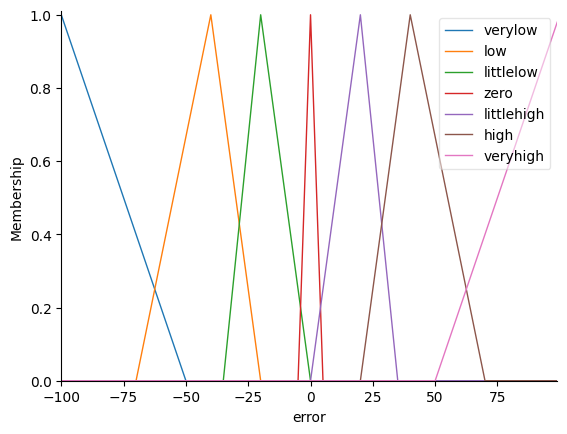

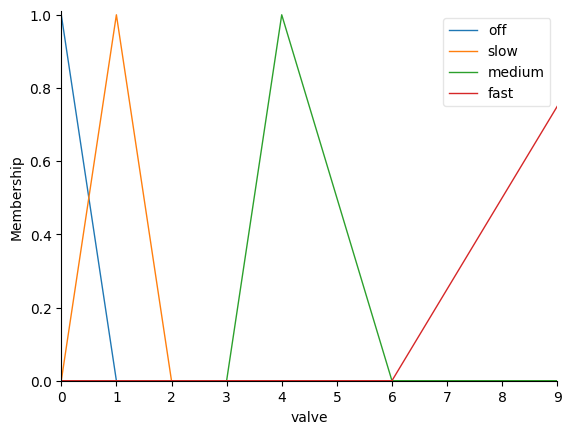

In [156]:
universe_error = np.arange(-100, 100, 1)
universe_valve = np.arange(0, 10, 1)
error = ctrl.Antecedent(universe_error,'error')
error['verylow'] = fuzz.trimf(error.universe, [-100, -100, -50])
error['low'] = fuzz.trimf(error.universe, [-70, -40, -20])
error['littlelow'] = fuzz.trimf(error.universe, [-35, -20, 0])
error['zero'] = fuzz.trimf(error.universe, [-5, 0, 5])
error['littlehigh'] = fuzz.trimf(error.universe, [0, 20, 35])
error['high'] = fuzz.trimf(error.universe, [20, 40, 70])
error['veryhigh'] = fuzz.trimf(error.universe, [50, 100, 100])

valve = ctrl.Consequent(universe_valve,'valve')
valve['off'] = fuzz.trimf(valve.universe, [0, 0, 1])
valve['slow'] = fuzz.trimf(valve.universe, [1, 1, 2])
valve['medium'] = fuzz.trimf(valve.universe, [3, 4, 6])
valve['fast'] = fuzz.trimf(valve.universe, [6, 10, 10])
error.view()
valve.view()

## Rules

Below, you should design the rules:

In [157]:
rule1 = ctrl.Rule(error['verylow']  | error['low'],         valve['fast'])
rule2 = ctrl.Rule(error['zero']     | error['littlelow'] ,   valve['medium'])
rule3 = ctrl.Rule(error['high']  | error['littlehigh']   ,  valve['slow'])
rule4 = ctrl.Rule(error['veryhigh'],                        valve['off'])

## Control system and simulation

Make a control system and a simulation:

In [158]:
tank_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
tank_sim = ctrl.ControlSystemSimulation(tank_ctrl)

The function below is called by the tank simulation code further down. If you make changes to the function, the code may not run.

In [159]:
# No changes needed to the code below:

def call_tank_sim(error):
  global tank_sim

  tank_sim.input['error'] = error
  tank_sim.compute()
  return tank_sim.output['valve']

## Run and test

The code below is to simulate the tank. You don't need to make any changes to the code. The ```call_tank_sim``` function above where your fuzzy controller is invoked is called every timestep. 

However, you can set ```animate=False``` if you are testing and want your code to run faster. You can also set ```simulation_length``` to something larger than 100 (should be divisible by 10) if you want to see how the system behaves over longer time scales.

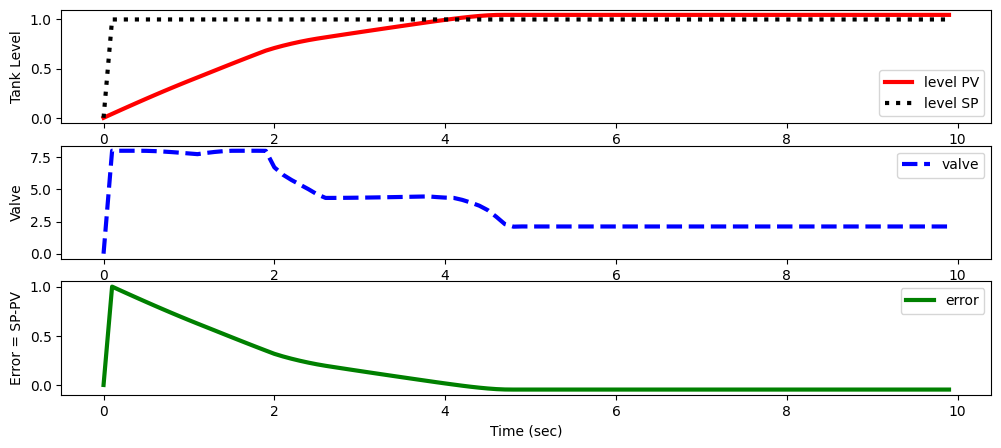

In [160]:
from IPython import display

import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# animate plots?
animate=True # True / False

simulation_length = 100

# define tank model
def tank(Level,time,c,valve):
    rho = 1000.0 # water density (kg/m^3)
    A = 1.0      # tank area (m^2)
    # calculate derivative of the Level
    dLevel_dt = (c/(rho*A)) * valve
    return dLevel_dt

# time span for the simulation for simulation_length//10 sec, every 0.1 sec
ts = np.linspace(0,simulation_length//10, simulation_length + 1)

# valve operation
c = 50.0          # valve coefficient (kg/s / %open)
u = np.zeros(simulation_length + 1) # u = valve % open

# level initial condition
Level0 = 0

# initial valve position
valve = 10

# proportion of water than flows out of the tank every timestep
outflow = 0.01

# for storing the results
z = np.zeros(simulation_length + 1)
es = np.zeros(simulation_length + 1)
sps = np.zeros(simulation_length + 1)

# record the desired level (set point)
SP = 1

plt.figure(1,figsize=(12,5))
if animate:
    plt.ion()
    plt.show()

# simulate with ODEINT
for i in range(simulation_length):
    # calculate the error
    error = SP - Level0

    valve = call_tank_sim(-error * 100)

    u[i+1] = valve   # store the valve position
    es[i+1] = error  # store the error 
    y = odeint(tank,Level0,[0,0.1],args=(c,valve))
    Level0 = y[-1] * (1.0 - outflow) # take the last point
    z[i+1] = Level0 # store the level for plotting
    sps[i+1] = SP

    if animate:
        # update plot
        display.clear_output(wait=True)
        plt.figure(1,figsize=(12,5))
        plt.subplot(3,1,1)
        plt.plot(ts[0:i+1],z[0:i+1],'r-',linewidth=3,label='level PV')
        plt.plot(ts[0:i+1],sps[0:i+1],'k:',linewidth=3,label='level SP')
        plt.ylabel('Tank Level')
        plt.legend(loc='best')
        plt.subplot(3,1,2)
        plt.plot(ts[0:i+1],u[0:i+1],'b--',linewidth=3,label='valve')
        plt.ylabel('Valve')    
        plt.legend(loc='best')
        plt.subplot(3,1,3)
        plt.plot(ts[0:i+1],es[0:i+1],'g-',linewidth=3,label='error')
        plt.ylabel('Error = SP-PV')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.pause(0.1)

if not animate:
    # plot results
    plt.subplot(3,1,1)
    plt.plot(ts,z,'r-',linewidth=3,label='level PV')
    plt.plot(ts,sps,'k:',linewidth=3,label='level SP')
    plt.ylabel('Tank Level')
    plt.legend(loc='best')
    plt.subplot(3,1,2)
    plt.plot(ts,u,'b--',linewidth=3,label='valve')
    plt.ylabel('Valve')    
    plt.legend(loc='best')
    plt.subplot(3,1,3)
    plt.plot(ts,es,'g-',linewidth=3,label='error')
    plt.ylabel('Error = SP-PV')    
    plt.xlabel('Time (sec)')
    plt.legend(loc='best')
    plt.show()